In [1]:
#%% Import necessary packages and functions
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.optimize 
from scipy.optimize import curve_fit

def find_nearest(array, value):
    #array is a 1D vector of wavelengths
    #value is the specific wavelength for which want the index
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def trim_data(x, data, limit1, limit2):
    #x is a 1D array of two theta or q values
    #data is an array of x-ray intensities
    #limit1 and limit2 are what you'd like to trime your data to 
    test = np.array(x)
    set1 = find_nearest(test,limit1)
    set2 = find_nearest(test,limit2)
    return x[set1:set2], data[set1:set2]

def back_abs(x, data, limit1, limit2):
    #x is a 1D array of wavelengths
    #data is an array of intensities
    #limit1 and limit2 are what you'd like to use for calculating background
    test = np.array(x)
    set1 = find_nearest(test,limit1)
    set2 = find_nearest(test,limit2)
    back = np.mean(data[set1:set2])
    data_correct=(data-back)
    return data_correct

def Wavelen2eV(wavelen):
    #wavelen: array like, an array of e&m wavelength in nm
    c_light = 2.99792458e8 * 1e9 #
    h_plank = 4.1357e-15 
    eV_tmp=[c_light/each*h_plank for each in wavelen]
    return np.array(eV_tmp)

def linear(x,m,b):
    return m*x + b

def tauc_fit(eV, taucscale, limit1, limit2):
    set1 = find_nearest(eV,limit1)
    set2 = find_nearest(eV,limit2)
    popt, pcov = curve_fit(linear, eV[set1:set2], taucscale[set1:set2])
    return -1*popt[1]/popt[0], popt



Bandgap 1.6287416933882 eV


Text(0, 0.5, 'Tauc Scale')

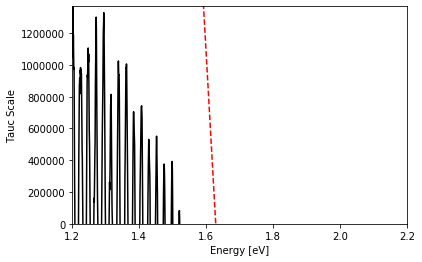

In [8]:
#%%     Update values for importing and analysis
path = r'ABS' #update for your directory
file_name = '/chem10_Transmission_13-46-47-762.txt' #update for your data

Abs_range = [2.2,1.2] #eV range to consider in 
Back_range = [1.4, 1.2] #eV range to for calucating background in eV
Fit_range = [1.69, 1.67] #eV range to do linear fitting of band edge

Thickness = 200*10**-9 #Approximate thickness of sample
Transition_Power = 1/2 #1/2 for direct, 2 for indirect, 3/2 for forbidden etc.

#   Process Data
transmission = pd.read_csv(path+file_name, delimiter = '\t', names =['Wavelength', 'Transmission'], skiprows=13) #read in data from ocean optics file
transmission = trim_data(Wavelen2eV(transmission['Wavelength']), transmission['Transmission'], Abs_range[0], Abs_range[1]) #trim data
absorption = [transmission[0], back_abs(transmission[0],(100-transmission[1])/100, Back_range[0], Back_range[1])] #Make new absorption file that is fraction of absoption vs. eV with background subtracts

#   Transfrom Data 
tauc_scale = [absorption[0], (absorption[0]*absorption[1]/Thickness)**1/Transition_Power]
E_g, fit = tauc_fit(tauc_scale[0],tauc_scale[1],Fit_range[0], Fit_range[1])
print('Bandgap', E_g, 'eV')
#   Plot fit
fig1, ax1 = plt.subplots()
ax1.plot(tauc_scale[0],tauc_scale[1], 'k-', label ='data')
ax1.plot(tauc_scale[0],linear(tauc_scale[0], fit[0], fit[1]), 'r--', label = 'fit')
ax1.set_ylim(0,np.max(tauc_scale[1]))
ax1.set_xlim(Abs_range[1],Abs_range[0])
ax1.set_xlabel('Energy [eV]')
ax1.set_ylabel('Tauc Scale')